# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [3]:
import numpy as np

np.__version__

'1.19.2'

In [4]:
import pandas as pd

pd.__version__

'1.2.3'

In [5]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [7]:
import seaborn as sns

sns.__version__

'0.11.1'

## Загрузка данных

[Источник (Churn Modelling)](https://www.kaggle.com/shrutimechlearn/churn-modelling)

In [8]:
df = pd.read_csv("./../../data/Churn_Modelling.csv", index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


## Разделение данных на `X` и `y`

In [10]:
# колонка, которая не несет полезной информации
# если добавить, то может испортить качество, так как
# номер пользователя объективно не должен влиять на результ
del df['CustomerId']

In [11]:
target_column_name = 'Exited'

In [12]:
from sklearn.model_selection import train_test_split

y = df[target_column_name].copy()
X = df.loc[:, df.columns != target_column_name].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Этап 1 ("Straightforward")

### Анализ и обработка пропущенных значений

In [13]:
df.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Преобразование типов и очистка

In [14]:
for col_name in X.select_dtypes(include='object'):
    print(f'{col_name} : {df[col_name].nunique()}')
    print('-' * 20)

Surname : 2932
--------------------
Geography : 3
--------------------
Gender : 2
--------------------


In [15]:
X['Surname'] = X.Surname.astype('string')
X['Geography'] = X.Geography.astype('string')
X['Gender'] = X.Gender.astype('category')

In [16]:
for col_name in X.select_dtypes(include=int):
    nunique = X[col_name].nunique()
    
    print(f'{col_name} : {nunique}')
    if nunique < 40:
        display(X[col_name].value_counts())
        if nunique == 2 and set(X[col_name].unique()) == {0, 1}:
            X[col_name] = X[col_name].astype('boolean')
            print('->boolean')
    print('-' * 20)

CreditScore : 460
--------------------
Age : 70
--------------------
Tenure : 11


2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

--------------------
NumOfProducts : 4


1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

--------------------
HasCrCard : 2


1    7055
0    2945
Name: HasCrCard, dtype: int64

->boolean
--------------------
IsActiveMember : 2


1    5151
0    4849
Name: IsActiveMember, dtype: int64

->boolean
--------------------


In [17]:
X['NumOfProducts'] = pd.Categorical(X['NumOfProducts'], ordered=True)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Surname          10000 non-null  string  
 1   CreditScore      10000 non-null  int64   
 2   Geography        10000 non-null  string  
 3   Gender           10000 non-null  category
 4   Age              10000 non-null  int64   
 5   Tenure           10000 non-null  int64   
 6   Balance          10000 non-null  float64 
 7   NumOfProducts    10000 non-null  category
 8   HasCrCard        10000 non-null  boolean 
 9   IsActiveMember   10000 non-null  boolean 
 10  EstimatedSalary  10000 non-null  float64 
dtypes: boolean(2), category(2), float64(2), int64(3), string(2)
memory usage: 683.9 KB


### Анализ баланса целевой переменной (`y`)

In [19]:
def plot_cat_count_s(cs: pd.Series):
    """
    Функция для рисования countplot для Series
    """
    
    # создать график (сетка 1x1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    # создать countplot
    g = sns.countplot(x=cs, 
                      ax=ax)

    # повернуть подписи категорий на 45 градусов
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')

    # отключить подпись оси x и y
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    # наименование графика справа цветом графика
    ax.set_title(cs.name, 
                 loc='right', 
                 fontsize=15)

    # включить сетку на графике
    ax.grid()

    # сколько всего записей для всех категорий в колонке
    total = len(cs)
    
    print(f"{total} ({cs.name})")

    # для каждого столбца на графике сверху добавить процент
    for p in ax.patches:
        # вычислить процент, который соответствует текущему столбцу
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)

        # начало (слева) столбца на графике по оси x
        x_pos = p.get_x()

        # верх столбца на графике по оси x
        y_pos = p.get_y() + p.get_height()

        # добавить процент в качестве аннотации к столбцу
        ax.annotate(percentage, 
                    xy=(x_pos, y_pos), 
                    fontsize=15)

10000 (Exited)


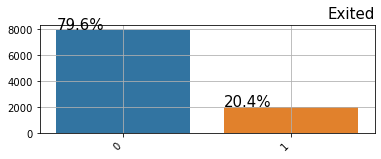

In [20]:
plot_cat_count_s(y)

Можно сказать, что имеется умеренная (moderate) несбалансированность классов.

### Анализ и обработка выбросов

In [21]:
def box_hist(data, col_name):
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data[col_name], ax=axs[0])
    sns.histplot(data=data[col_name], ax=axs[1])

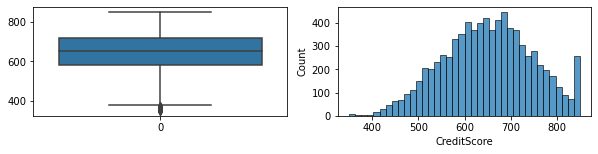

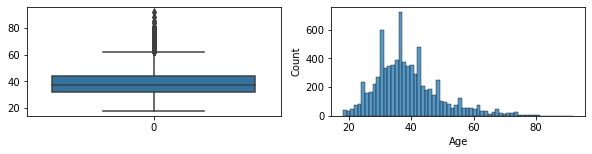

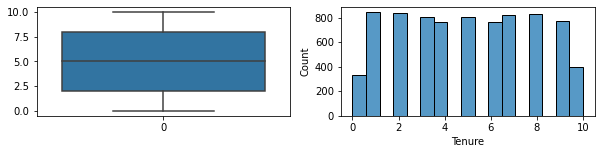

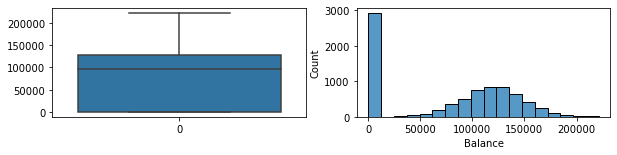

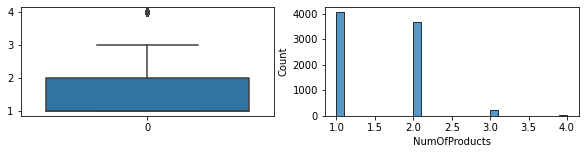

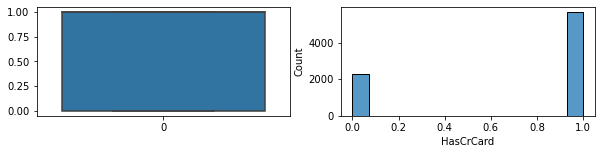

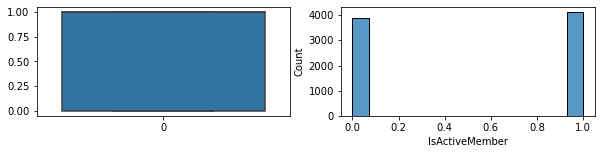

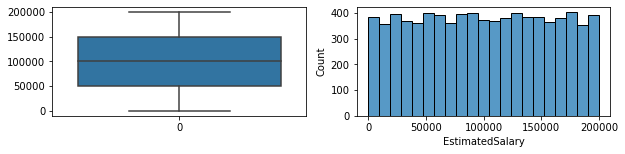

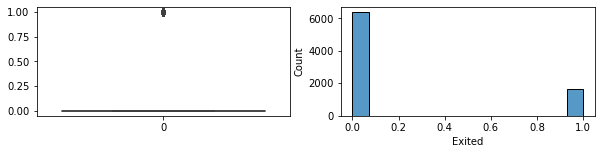

In [22]:
df_tmp = X_train.join(y_train).reset_index(drop=True)
for col_name in df.select_dtypes(include=np.number):
    box_hist(df_tmp, col_name)

X_train = df_tmp.loc[:, df_tmp.columns != target_column_name].copy()
y_train = df_tmp[target_column_name].copy()

### Pipeline

In [23]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [24]:
cat_columns = X.select_dtypes(include='category').columns.tolist()
bin_cat_columns = [col_name for col_name in X[cat_columns] if X[col_name].nunique() == 2]
mul_cat_columns = [col_name for col_name in cat_columns if col_name not in bin_cat_columns]
bool_columns = X.select_dtypes(include='bool').columns.tolist()
bin_columns = bin_cat_columns + bool_columns

num_columns = X.select_dtypes(include=np.number).columns.tolist()

str_columns = X.select_dtypes(include='string').columns.tolist()

print(f"cat_columns: {cat_columns}\nbin_cat_columns: {bin_cat_columns}\nmul_cat_columns: {mul_cat_columns}\nbool_columns: {bool_columns}\nbin_columns: {bin_columns}")
print(f"num_columns: {num_columns}")
print(f"str_columns: {str_columns}")

cat_columns: ['Gender', 'NumOfProducts']
bin_cat_columns: ['Gender']
mul_cat_columns: ['NumOfProducts']
bool_columns: ['HasCrCard', 'IsActiveMember']
bin_columns: ['Gender', 'HasCrCard', 'IsActiveMember']
num_columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
str_columns: ['Surname', 'Geography']


In [25]:
bin_cat_transformer = Pipeline(steps=[
    ('encoder_ord', OrdinalEncoder())
])

In [26]:
mul_cat_transformer = Pipeline(steps=[
    ('astype_int', FunctionTransformer(lambda x: x.astype(int)))
])

In [27]:
num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_cat_transformer', bin_cat_transformer, bin_columns),
        ('mul_cat_transformer', mul_cat_transformer, mul_cat_columns),
        ('num_transformer', num_transformer, num_columns),
        ('drop', 'drop', str_columns),
])

In [29]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier())
])

In [30]:
X[bin_columns + mul_cat_columns + num_columns]

,Gender,HasCrCard,IsActiveMember,NumOfProducts,CreditScore,Age,Tenure,Balance,EstimatedSalary
RowNumber,,,,,,,,,
1,Female,True,True,1,619,42,2,0.00,101348.88
2,Female,False,True,1,608,41,1,83807.86,112542.58
3,Female,True,False,3,502,42,8,159660.80,113931.57
4,Female,False,False,2,699,39,1,0.00,93826.63
5,Female,True,True,1,850,43,2,125510.82,79084.10
...,...,...,...,...,...,...,...,...,...
9996,Male,True,False,2,771,39,5,0.00,96270.64
9997,Male,True,True,1,516,35,10,57369.61,101699.77
9998,Female,False,True,1,709,36,7,0.00,42085.58


In [31]:
prep_for_test = preprocessor.fit(X_train, y_train)
pd.DataFrame(prep_for_test.transform(X_train), columns=bin_columns + mul_cat_columns + num_columns)

,Gender,HasCrCard,IsActiveMember,NumOfProducts,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,0.0,1.0,1.0,1.0,0.629630,-0.083333,0.500000,0.055968,0.098462
1,0.0,1.0,0.0,1.0,-1.200000,0.750000,0.500000,-0.037015,0.475314
2,0.0,1.0,0.0,2.0,-0.370370,-0.250000,0.000000,-0.759130,-0.742791
3,1.0,1.0,0.0,1.0,-1.118519,1.583333,-0.666667,0.028204,0.184144
4,1.0,1.0,0.0,1.0,-0.081481,-1.166667,-0.333333,-0.194265,0.618306
...,...,...,...,...,...,...,...,...,...
7995,1.0,0.0,1.0,1.0,0.392593,-0.083333,-0.333333,0.137987,-0.339582
7996,1.0,1.0,0.0,1.0,1.029630,-0.416667,-0.333333,-0.759130,-0.093996
7997,1.0,1.0,0.0,1.0,0.451852,-0.250000,0.500000,0.135774,-0.076260
7998,0.0,1.0,0.0,2.0,0.666667,-0.083333,-0.833333,0.242351,-0.264088


[scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

In [32]:
# Параметры конвейеров могут быть заданы с использованием имен параметров, разделенных __
param_grid = {
    'model__max_depth': list(range(1, 8)),
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': list(range(2, 8))
}
model = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model.best_score_)
print(model.best_params_)

Best parameter (CV score=0.835):
{'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_split': 6}


In [33]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('./tmp/pipeline.html', 'w') as f:
    f.write(estimator_html_repr(model.best_estimator_))

# the best estimator from grid search
model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bin_cat_transformer',
                                                  Pipeline(steps=[('encoder_ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('mul_cat_transformer',
                                                  Pipeline(steps=[('astype_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f499a3a6820>))]),
                                                  ['NumOfProducts']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('drop', 'drop',
                                                  ['Surname', 'Geography'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_split=6))])

### Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [34]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.845  0.83   0.825  0.8425 0.8725]
0.84 accuracy with a standard deviation of 0.02


### Оценка качества модели (Evaluation)

In [35]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

In [36]:
y_predicted = model.predict(X_test)

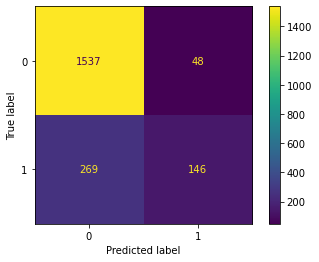

In [37]:
plot_confusion_matrix(model, X_test, y_test)

In [38]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1585
           1       0.75      0.35      0.48       415

    accuracy                           0.84      2000
   macro avg       0.80      0.66      0.69      2000
weighted avg       0.83      0.84      0.82      2000



In [42]:
accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted, average='weighted')
roc_auc = roc_auc_score(y_test, y_predicted)

print(f"accuracy = {accuracy:.3f}\nprecision = {precision:.3f}\nrecall = {recall:.3f}\nf1 = {f1:.3f}\nroc_auc = {roc_auc:.3f}")

accuracy = 0.842
precision = 0.753
recall = 0.352
f1 = 0.818
roc_auc = 0.661


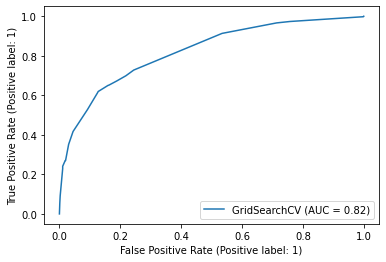

In [40]:
plot_roc_curve(model, X_test, y_test)

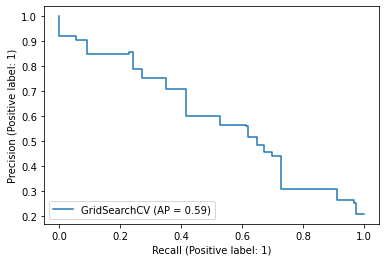

In [41]:
plot_precision_recall_curve(model, X_test, y_test)